# 0. IMPORTS

In [1]:
import random
import math
import numpy as np
import pandas as pd
import warnings
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import datetime
import xgboost as xgb


from scipy import stats
from flask import Flask, request, Response
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error)

from boruta import BorutaPy

# sns.set_palette('icefire')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'models_name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


def mean_percentage_error(y, yhat):
    return np.mean(y - yhat)


def cramerv(x, y):
    cm = pd.crosstab(x, y).values
    chi2 = stats.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    v = np.sqrt((chi2/n) / min(k-1, r-1))
    
    chi2_corr = max(0, chi2 - (((k-1)*(r-1)) / (n-1)))
    k_corr = k - (k-1)**2 / (n-1)
    r_corr = r - (r-1)**2 / (n-1)
    v_corr = np.sqrt((chi2_corr/n) / min(k_corr-1, r_corr-1))
    
    return v_corr


def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in range(kfold, 0, -1):
        if verbose:
            print('KFold Number: {}'.format(kfold + 1 - k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=7*6*k)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=7*6*(k-1))

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop(['date', 'sales'], axis=1) 
        ytraining = training['sales']
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1. DESCRICAO DOS DADOS

In [4]:
df1 = df_raw.copy()

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# def snakecase(x):
#     return inflection.underscore(x)

# cols_new = list(map(snakecase, cols_old))
cols_new = ['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval']

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [15]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6])
m = m.T
m.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,min,max,range,mean,median,std,skew,kurtosis
store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


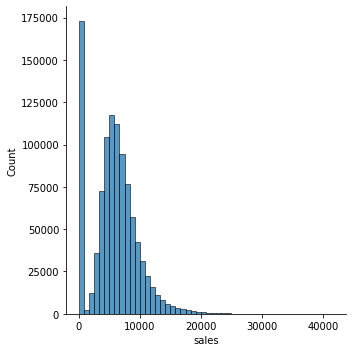

In [16]:
sns.displot(df1['sales'], bins=50)

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

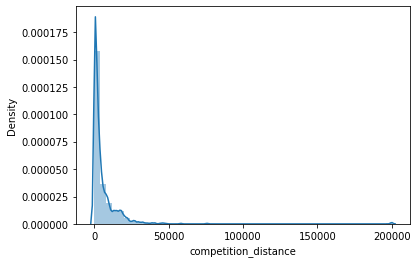

In [17]:
sns.distplot(df1['competition_distance'], bins=50)

### 1.7.2. Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [19]:
cat_attributes.describe()

,state_holiday,store_type,assortment,promo_interval,month_map
count,1017209,1017209,1017209,1017209,1017209
unique,4,4,3,4,12
top,0,a,a,0,Mar
freq,986159,551627,537445,508031,103695


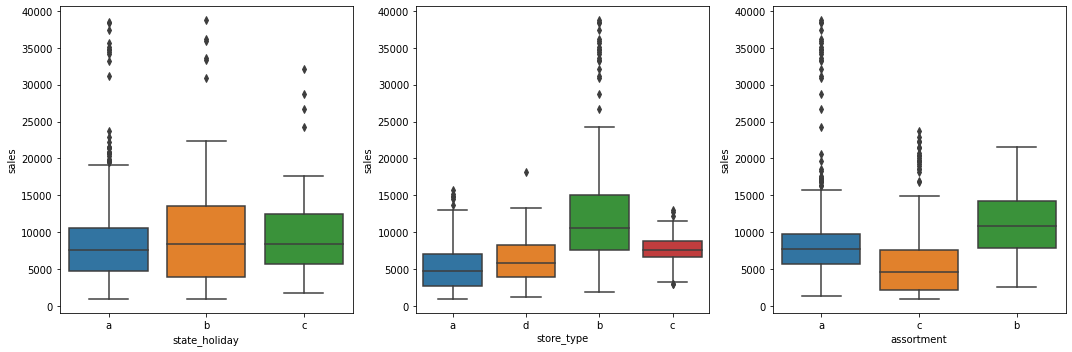

In [20]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

plt.tight_layout()

# 2. FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

![Mind Map Hypothesis](img/MindMapHypothesis.png)

## 2.2. Criação das Hipoteses

### 2.2.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição do produto deveriam vender mais

**3.** Lojas com produtos com preço menos deveriam vender mais

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre dos ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveria vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre dos ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveria vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [22]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [23]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3. FILTRAGEM DE VARIAVEIS

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [28]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4. EXPLORATORY DATA ANALYSIS

In [29]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [30]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

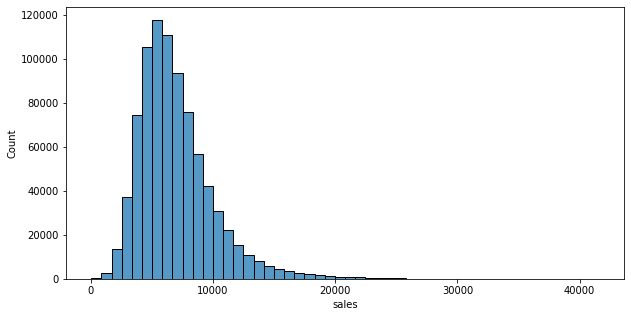

In [31]:
plt.figure(figsize=(10,5))
sns.histplot(data=df4, x='sales', bins=50)
# df4['sales'].hist(figsize=(10, 5), bins=50, grid=False)

### 4.1.2 Numerical Variable

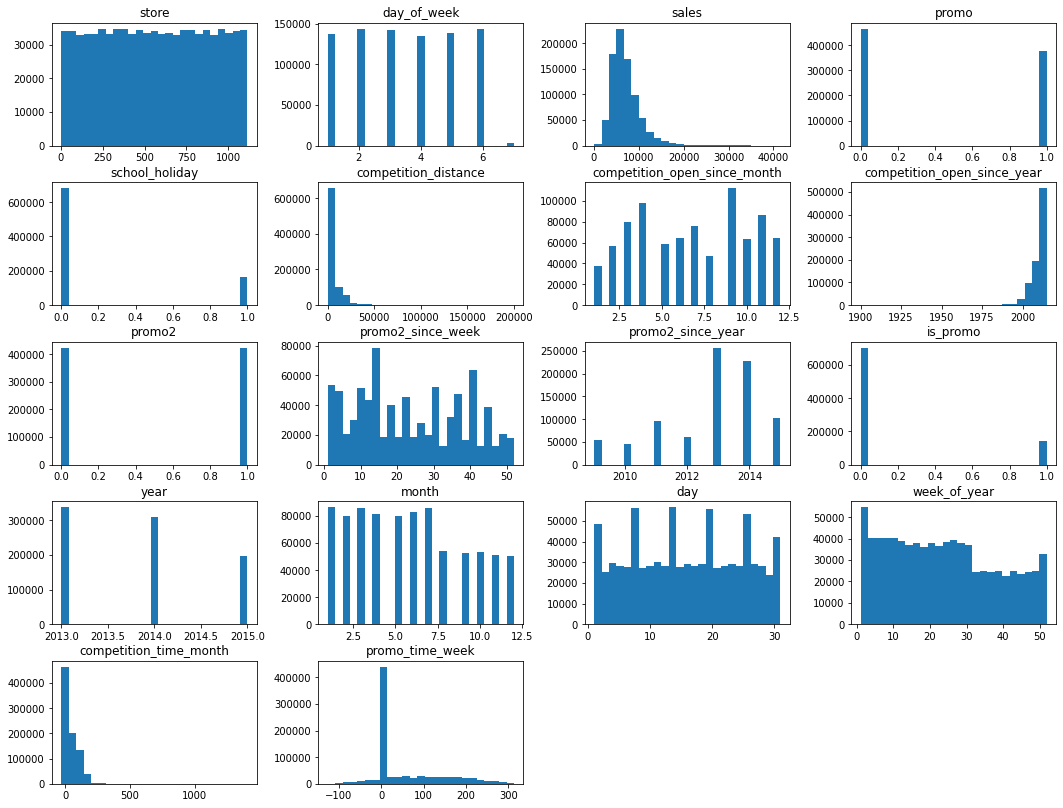

In [32]:
num_attributes.hist(bins=25, figsize=(18, 14), grid=False);

In [33]:
# Resumo descritivo "is_promo"
print('Resumo descritivo "is_promo"')
print('Minimum:  {:.2f}'.format(df4['is_promo'].min()))
print('Maximum:  {:.2f}'.format(df4['is_promo'].max()))
print('Std:      {:.2f}'.format(df4['is_promo'].std()))
print('Range:    {:.2f}'.format(df4['is_promo'].max() - df4['is_promo'].min()))
print('Kurtosis: {:.2f}'.format(df4['is_promo'].kurtosis()))
print('Skew:     {:.2f}'.format(df4['is_promo'].skew()))

Resumo descritivo "is_promo"
Minimum:  0.00
Maximum:  1.00
Std:      0.37
Range:    1.00
Kurtosis: 1.22
Skew:     1.80


### 4.1.3 Categorical Variable

In [34]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

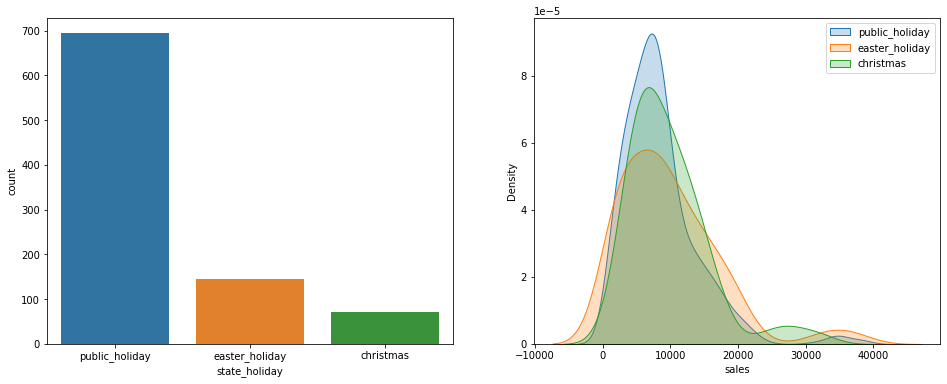

In [35]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data=a, x='state_holiday')

plt.subplot(1, 2, 2)
sns.kdeplot(df4.loc[df4['state_holiday'] == 'public_holiday', 'sales'], label='public_holiday', shade=True)
sns.kdeplot(df4.loc[df4['state_holiday'] == 'easter_holiday', 'sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4.loc[df4['state_holiday'] == 'christmas', 'sales'], label='christmas', shade=True)
plt.legend()

In [36]:
df4['store_type'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

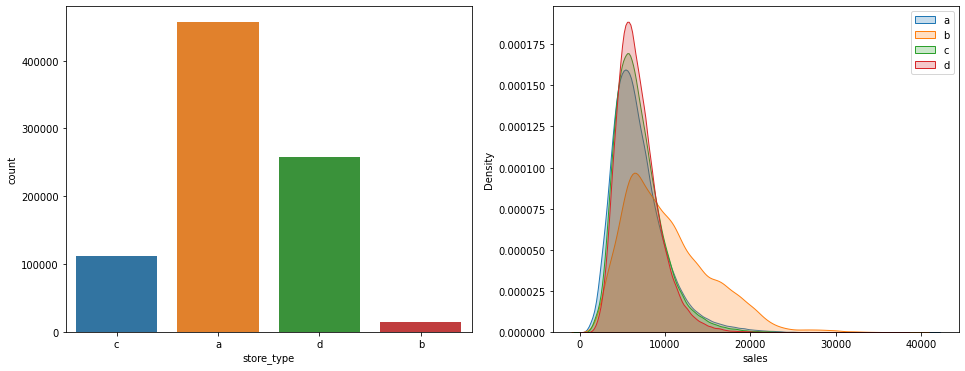

In [37]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
sns.countplot(data=df4, x='store_type')

plt.subplot(1, 2, 2)
sns.kdeplot(df4.loc[df4['store_type'] == 'a', 'sales'], label='a', shade=True)
sns.kdeplot(df4.loc[df4['store_type'] == 'b', 'sales'], label='b', shade=True)
sns.kdeplot(df4.loc[df4['store_type'] == 'c', 'sales'], label='c', shade=True)
sns.kdeplot(df4.loc[df4['store_type'] == 'd', 'sales'], label='d', shade=True)
plt.legend()

In [38]:
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

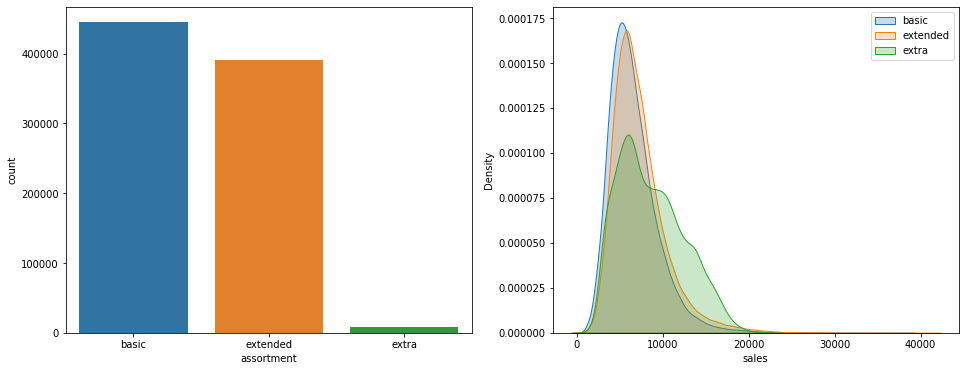

In [39]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
sns.countplot(data=df4, x='assortment')

plt.subplot(1, 2, 2)
sns.kdeplot(df4.loc[df4['assortment'] == 'basic', 'sales'], label='basic', shade=True)
sns.kdeplot(df4.loc[df4['assortment'] == 'extended', 'sales'], label='extended', shade=True)
sns.kdeplot(df4.loc[df4['assortment'] == 'extra', 'sales'], label='extra', shade=True)
plt.legend()

## 4.2. Bivariate Analysis

### H1. Lojas com maior sortimento deveriam vender mais.
**FALSO** - Lojas com MAIOR SORTIMENTO vendem MENOS

In [40]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

<AxesSubplot:xlabel='assortment', ylabel='sales'>

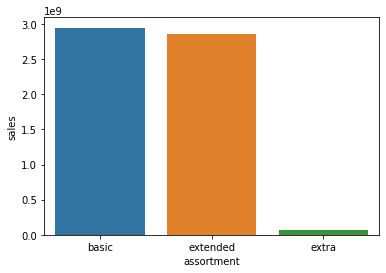

In [41]:
sns.barplot(data=aux1, x='assortment', y='sales')

In [42]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week' ,'assortment']).sum().reset_index()

In [43]:
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


<AxesSubplot:xlabel='year_week'>

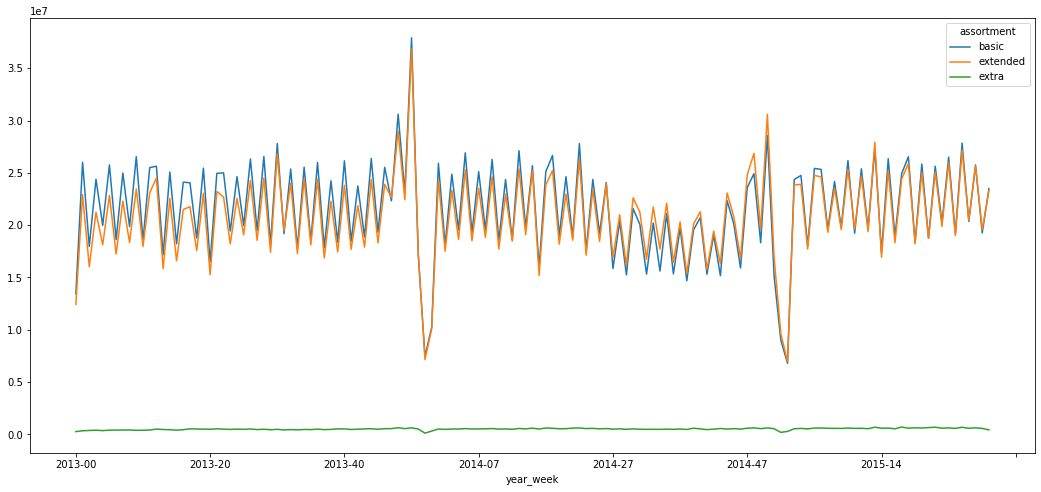

In [44]:
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(18,8))

<AxesSubplot:xlabel='year_week'>

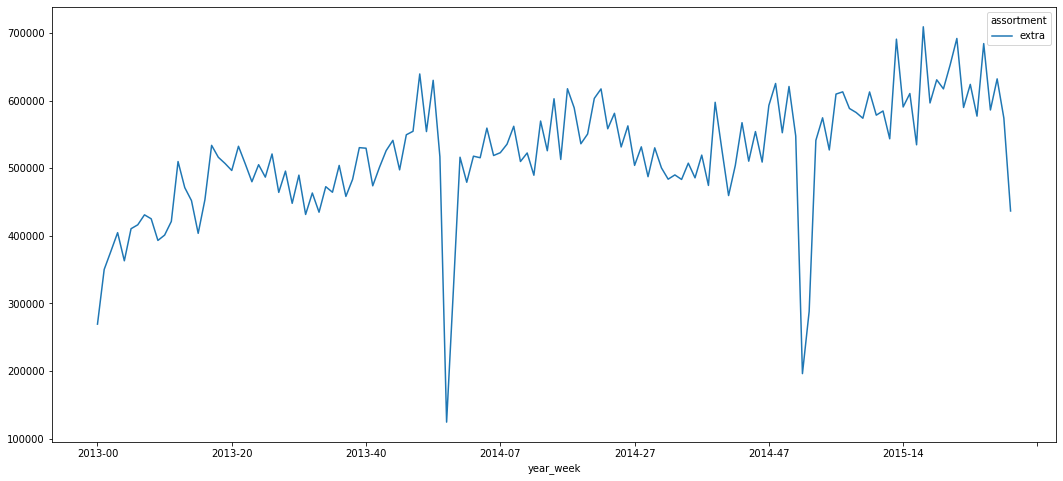

In [45]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(18, 8))

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSO** - Lojas com COMPETIDORES mais PRÓXIMOS vendem MAIS

<AxesSubplot:>

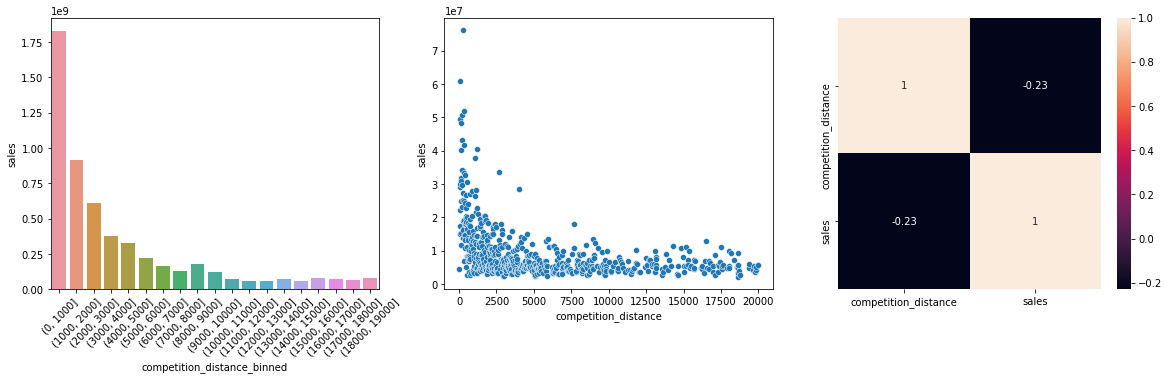

In [46]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.barplot(data=aux2, x='competition_distance_binned', y='sales', )
plt.xticks(rotation=45);

plt.subplot(1, 3, 2)
sns.scatterplot(data=aux1[aux1['competition_distance'] < 20000], x='competition_distance', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

# plt.title('competition_distance Analysis')

<AxesSubplot:>

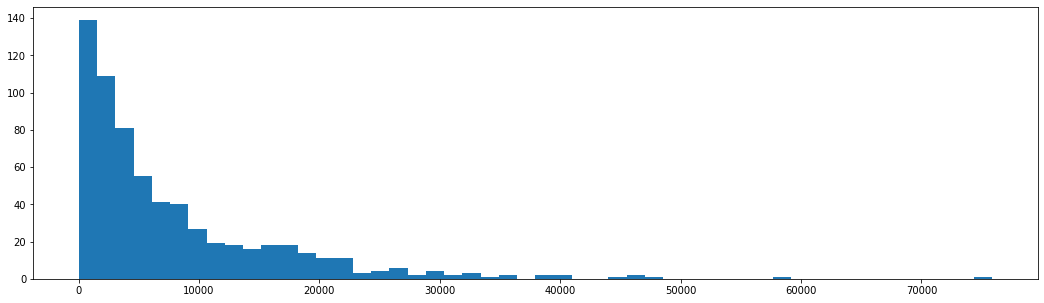

In [47]:
aux1.loc[aux1['competition_distance'] < 200000, 'competition_distance'].hist(bins=50, figsize=(18, 5), grid=False)

### H3. Lojas com competidores há mais tempo deveriam vender mais.
**FALSO** - Lojas com competidores há MAIS TEMPO vendem MENOS

<AxesSubplot:>

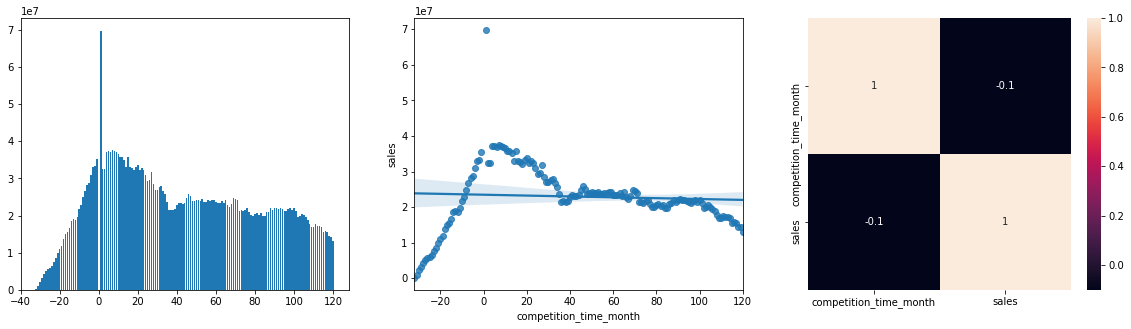

In [48]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <= 120) & (aux1['competition_time_month'] != 0)]

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
# sns.barplot(data=aux2, x='competition_time_month', y='sales')
plt.bar(x=aux2['competition_time_month'], height=aux2['sales'])

plt.subplot(1, 3, 2)
sns.regplot(data=aux2, x='competition_time_month', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSO** - Lojas com promoções ativas por mais tempo vendem menos depois de um certo tempo de promoção

<AxesSubplot:>

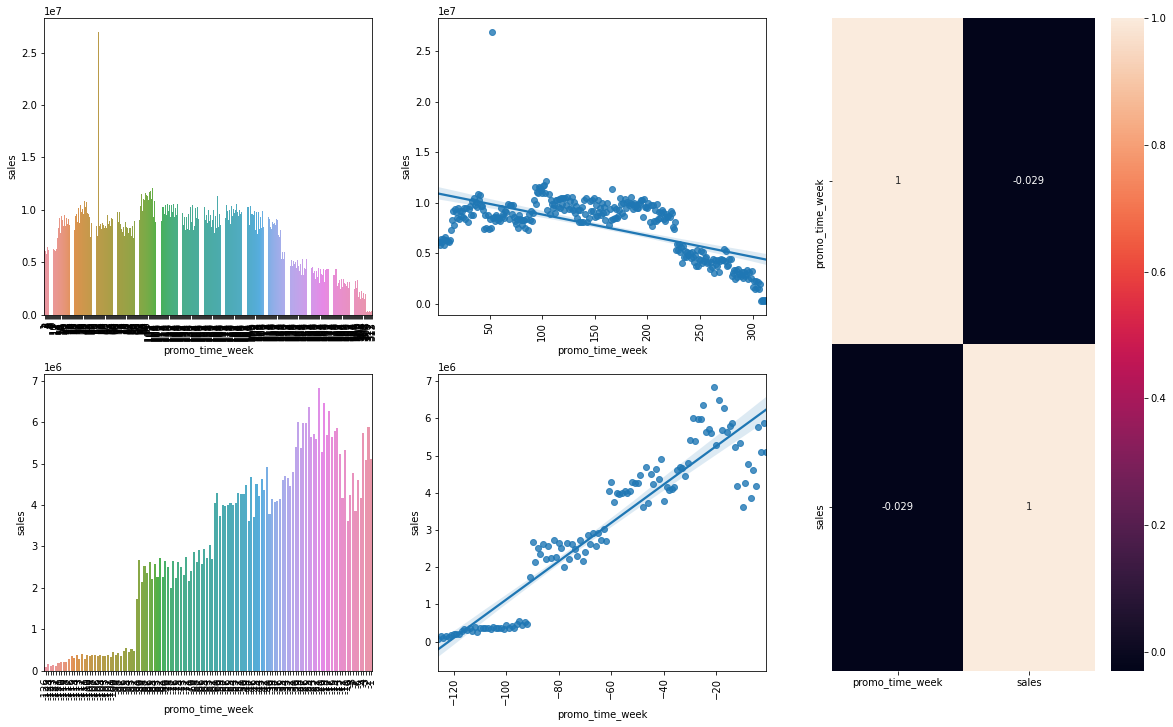

In [49]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
# sns.barplot(data=aux1, x='promo_time_week', y='sales')

aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular

plt.figure(figsize=(20,12))

grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, 0])
sns.barplot(data=aux2, x='promo_time_week', y='sales')
# plt.bar(x=aux2['promo_time_week'], height=aux2['sales'])
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(data=aux2, x='promo_time_week', y='sales')
plt.xticks(rotation=90);

plt.subplot(grid[1, 0])
sns.barplot(data=aux3, x='promo_time_week', y='sales')
# plt.bar(x=aux3['promo_time_week'], height=aux3['sales'])
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(data=aux3, x='promo_time_week', y='sales')
plt.xticks(rotation=90);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSO** - Lojas com mais promoções consecutivas vendem menos

In [50]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


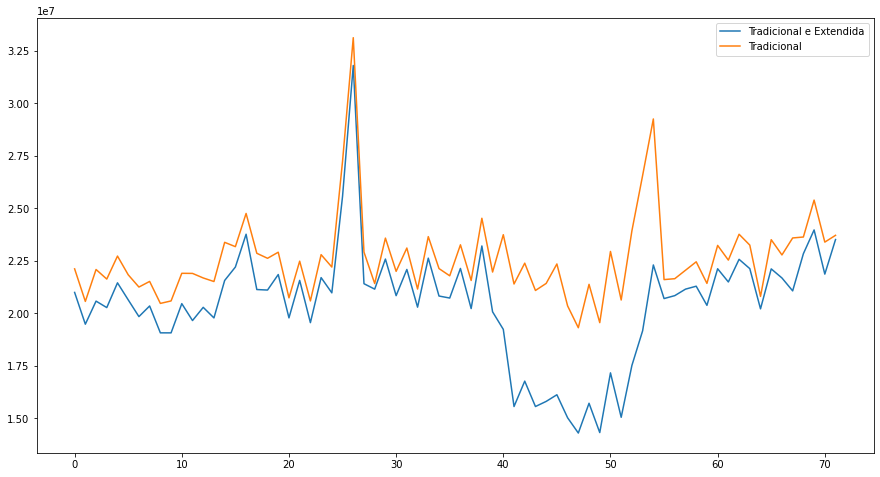

In [51]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(15,8))

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida', 'Tradicional'])

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSO** - Lojas abertas durante o feriado de Natal vendem menos

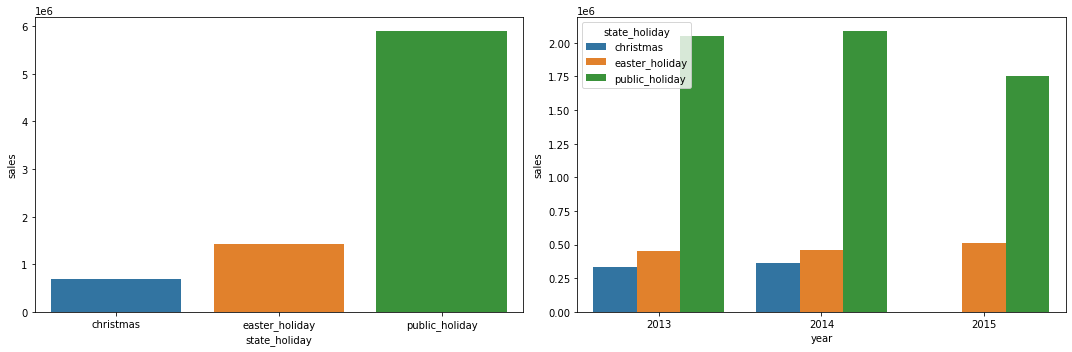

In [52]:
aux = df4[df4['state_holiday']  != 'regular_day']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data=aux1, x='state_holiday', y='sales')

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday')

plt.tight_layout()

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSO** - Lojas vendem menos ao longo dos anos

<AxesSubplot:>

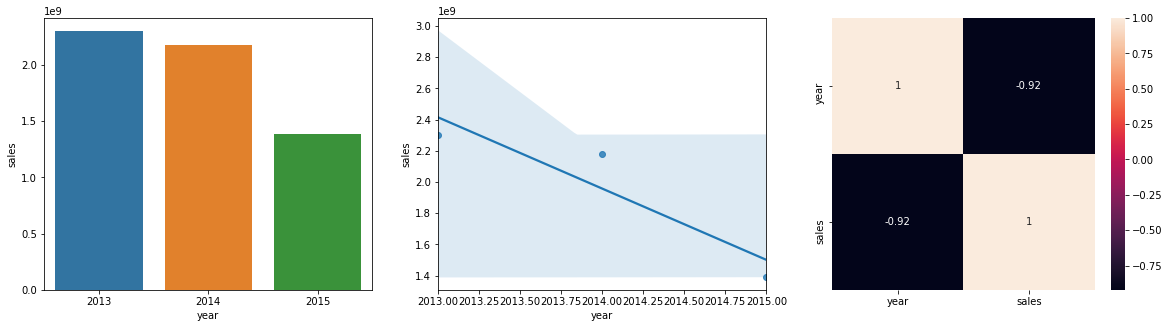

In [53]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='year', y='sales')

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='year', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)

### H9. Lojas deveriam vender mais no segundo semestre dos ano.
**FALSO** Lojas apresentam quedas nas vendas apos o 6° mês, com um aumento em dezembro.

<AxesSubplot:>

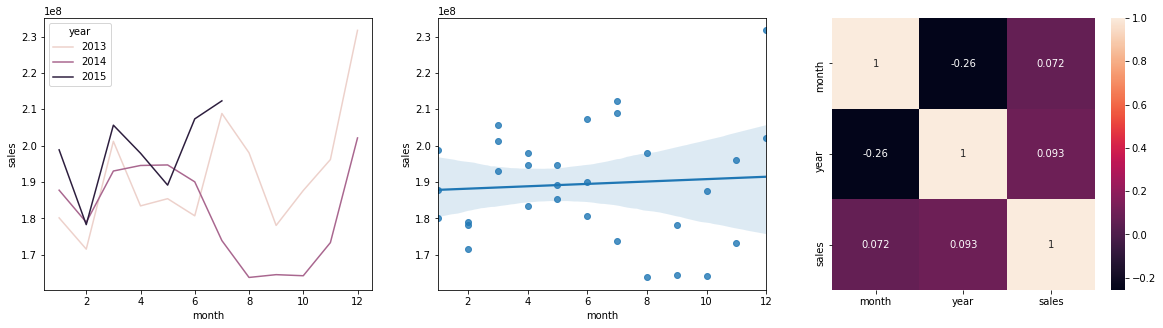

In [54]:
aux1 = df4[['month', 'year', 'sales']].groupby(['month', 'year']).sum().reset_index()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.lineplot(data=aux1, x='month', y='sales', hue='year')

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='month', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRO** - Lojas vendem mais após o dia 10. 

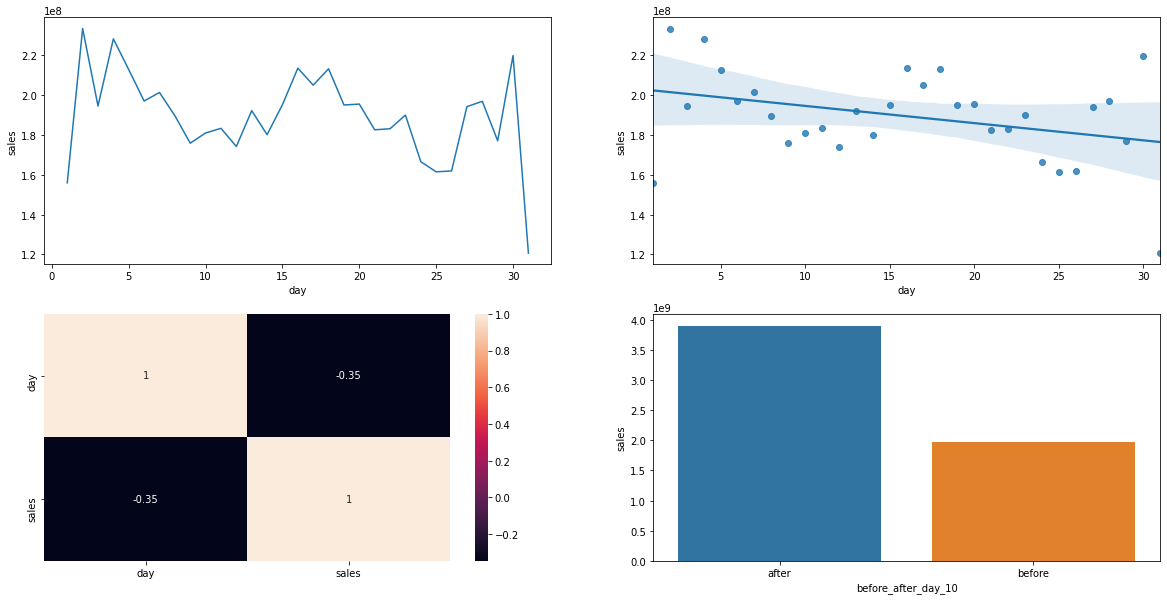

In [55]:
aux1 = df4[['day', 'sales']].groupby(['day']).sum().reset_index()
aux1['before_after_day_10'] = aux1['day'].apply(lambda x: 'before' if x <= 10 else 'after')

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
sns.lineplot(data=aux1, x='day', y='sales');

plt.subplot(2, 2, 2)
sns.regplot(data=aux1, x='day', y='sales');

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(), annot=True);

aux2 = aux1[['before_after_day_10', 'sales']].groupby('before_after_day_10').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(data=aux2, x='before_after_day_10', y='sales');

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO** - Lojas vendem menos aos finais de semana.

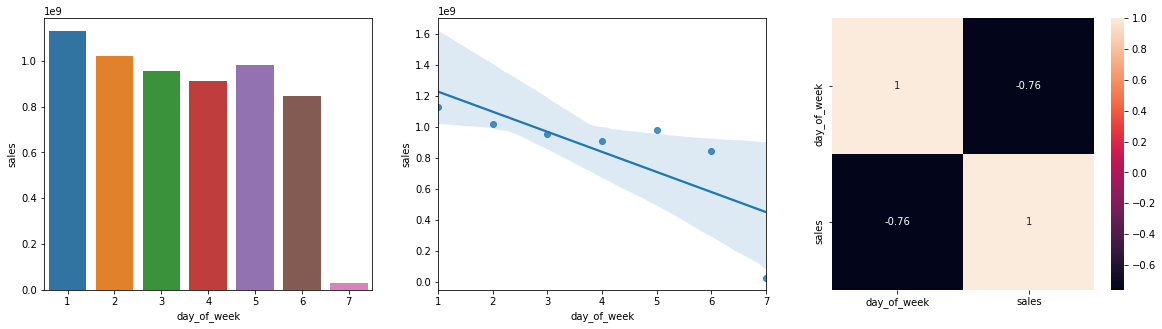

In [56]:
aux1 = df4[['day_of_week', 'sales']].groupby(['day_of_week']).sum().reset_index()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**FALSO** - Lojas vendem, em media, mais durante os feriados escolares.

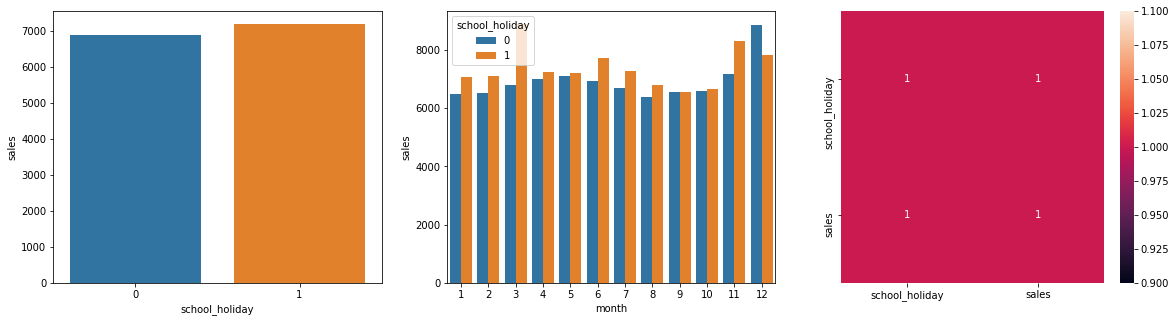

In [57]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).mean().reset_index()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='school_holiday', y='sales');

plt.subplot(1, 3, 2)
sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### 4.2.1. Resumo das Hipóteses

|Hipotese|Conclusão|Relevânicia|
|---|---|---|
|H1 |Falsa     |Baixa|
|H2 |Falsa     |Media|
|H3 |Falsa     |Media|
|H4 |Falsa     |Baixa|
|H5 |-         |-    |
|H6 |Falsa     |Baixa|
|H7 |Falsa     |Media|
|H8 |Falsa     |Alta |
|H9 |Falsa     |Alta |
|H10|Verdadeira|Alta |
|H11|Verdadeira|Alta |
|H12|Verdadeira|Baixa|

## 4.3. Multivariate Analysis

### 4.3.1 Numerical Attributes

<AxesSubplot:>

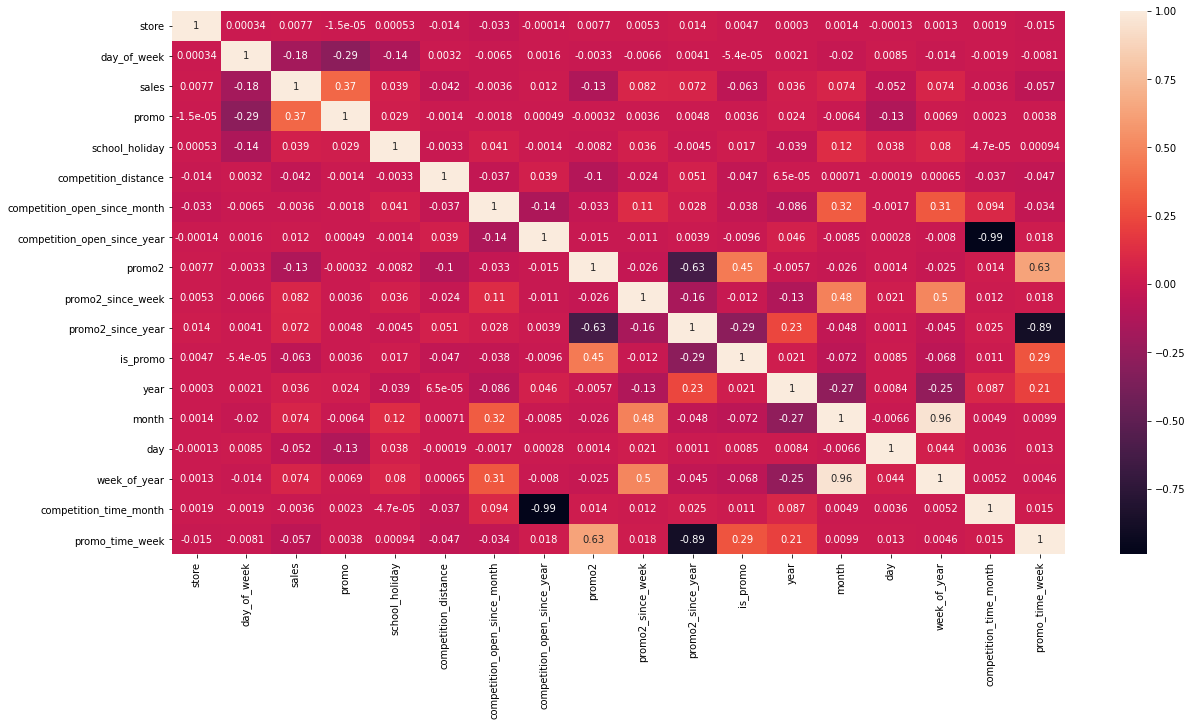

In [58]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [59]:
a = df4.select_dtypes(include=['object']).drop('year_week', axis=1)
a.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


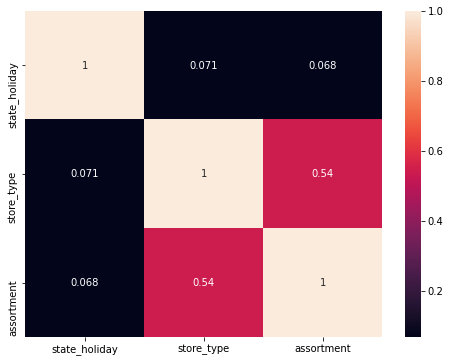

In [60]:
d = pd.DataFrame()
aux = []
for i in a.columns:
    for j in a.columns:
        v = cramerv(a[i], a[j])
        aux.append(v)
    d[i] = aux.copy()
    aux.clear()
d = d.set_index(d.columns)

plt.figure(figsize=(8,6))
sns.heatmap(d, annot=True);

# 5. DATA PREPARATION

In [61]:
df5 = df4.copy()

## 5.1 Standardization

In [62]:
# Nenhuma variável com distribuição próxima à normal

## 5.2 Rescaling

In [63]:
a = df5.select_dtypes(include=['int64', 'float64'])

<AxesSubplot:xlabel='year'>

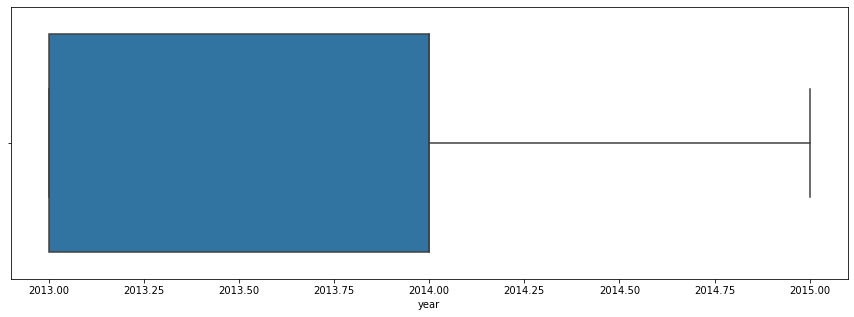

In [64]:
plt.figure(figsize=(15,5))
sns.boxplot(df5['year'])

In [65]:
rs = RobustScaler()
mms = MinMaxScaler()

In [66]:
# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('./parameters/scaler_competition_distance.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('./parameters/scaler_year.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('./parameters/scaler_competition_time_month.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('./parameters/scaler_promo_time_week.pkl', 'wb'))

<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

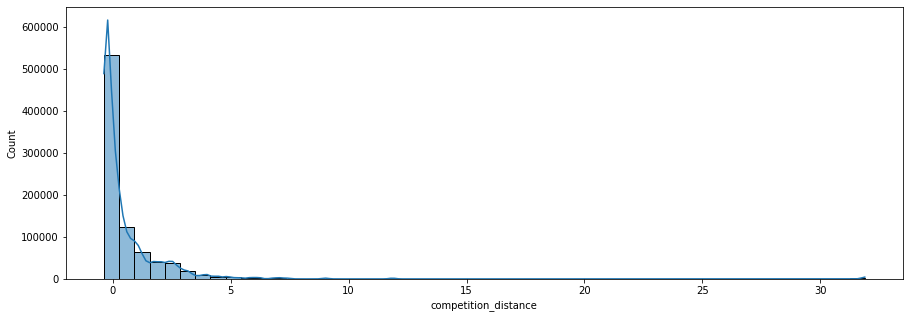

In [67]:
plt.figure(figsize=(15,5))
sns.histplot(df5['competition_distance'], bins=50, kde=True)

## 5.3 Transformation

### 5.3.1 Encoding

In [68]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('./parameters/encoder_store_type.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [69]:
df5['sales'] = np.log1p(df5['sales'])

<AxesSubplot:>

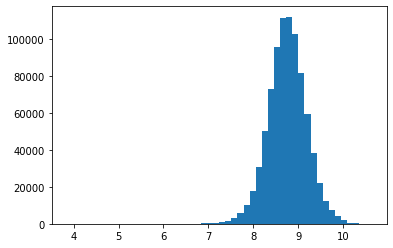

In [70]:
df5['sales'].hist(bins=50, grid=False)

### 5.3.3 Nature Transformation

In [71]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * 2 * np.pi / 7))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * 2 * np.pi / 7))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * 2 * np.pi / 12))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * 2 * np.pi / 12))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * 2 * np.pi / 30))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * 2 * np.pi / 30))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * 2 * np.pi / 52))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * 2 * np.pi / 52))

In [72]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6. FEATURE SELECTION

In [73]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [74]:
cols_drop = ['day_of_week', 'month', 'day', 'week_of_year', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [75]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [76]:
#training set
X_train = df6[df6['date'] < '2015-06-19']
y_train = df6[df6['date'] < '2015-06-19']['sales']

#test set
X_test = df6[df6['date'] >= '2015-06-19']
y_test = df6[df6['date'] >= '2015-06-19']['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
print()
print('Test Min Date: {}'.format(X_test['date'].min()))
print('Test Min Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [77]:
# # training and testing dataset for boruta
# X_train_n = X_train.drop(['sales', 'date'], axis=1).values
# y_train_n = y_train.values.ravel()

# # Define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # Define boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1. Best Features from Boruta

In [78]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

# cols_selected_boruta

## 6.3. Manual Feature Selection

In [79]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [80]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7. MACHINE LEARNING MODELING

In [81]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [82]:
# aux1 = x_test.copy()
# aux1['sales'] = y_test.copy()

# # prediction
# aux2 = aux1[['sales', 'store']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
# aux1 = pd.merge(aux1, aux2, on='store', how='left')
# yhat_baseline = aux1['predictions']

# # performance
# baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
# baseline_result

## 7.2. Linear Regression Model

In [83]:
# # model
# lr = LinearRegression().fit(x_train, y_train)

# # prediction
# yhat_lr = lr.predict(x_test)

# # performance
# lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
# lr_result

### 7.2.1. Linear Regression Model - Cross Validation

In [84]:
# lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', model=lr)
# lr_result_cv

## 7.3. Linear Regression Regularized Model - Lasso

In [85]:
# # model
# lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# # prediction
# yhat_lrr = lrr.predict(x_test)

# # performance
# lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
# lrr_result

### 7.3.1. Linear Regression Regularized Model - Cross Validation

In [86]:
# lrr_result_cv = cross_validation(x_training, 5, 'Lasso', model=lrr)
# lrr_result_cv

## 7.4. Random Forest Regressor

In [87]:
# # model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# # prediction
# yhat_rf = rf.predict(x_test)

# # performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

### 7.4.1. Random Forest Regressor - Cross Validation

In [88]:
# rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', model=rf)
# rf_result_cv

## 7.5. XGBoost Regressor

In [89]:
# # model
# model_xgb = xgb.XGBRegressor().fit(x_train, y_train)

# # prediction
# yhat_xgb = model_xgb.predict(x_test)

# # performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
# xgb_result

### 7.5.1. XGBoost Regressor - Cross Validation

In [90]:
# xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model=model_xgb)
# xgb_result_cv

## 7.6. Compare Model's Performance

In [91]:
# modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result]).reset_index().drop('index', axis=1)
# modelling_result.sort_values('RMSE')

### 7.6.1 Compare Model's Performance - Cross Validation

In [92]:
# modelling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv]).reset_index().drop('index', axis=1)
# modelling_result.sort_values('RMSE CV')

# 8. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [93]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 10

In [94]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
    
#     # chose values for parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
#     # model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'])

#     # performance
#     result = cross_validation(x_training, 5, 'XGBoost Regressor', model=model_xgb)
#     final_result = pd.concat([final_result, result])
# final_result

## 8.2. Grid Search

In [95]:
# Not used in this project

## 8.3. Bayesian Search

In [96]:
# Not used in this project

## 8.4. Final Model

In [97]:
# # model
# model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
#                                    n_estimators=3000,
#                                    eta=0.03,
#                                    max_depth=5,
#                                    subsample=0.7,
#                                    colsample_bytree=0.7,
#                                    min_child_weight=3).fit(x_train, y_train)

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# # performance
# xgb_tuned_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
# xgb_tuned_result

In [98]:
# mpe = mean_percentage_error(npexpm1(y_test), npexpm1(yhat_xgb_tuned))
# mpe

In [99]:
# pickle.dump(model_xgb_tuned, open('./model_rossmann.pkl', 'wb'))

In [100]:
model_xgb_tuned = pickle.load(open('./model/model_rossmann.pkl', 'rb'))

In [101]:
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# 9. TRANSLATION AND INTERPRETATION OF THE ERROR

In [102]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [103]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, on='store', how='inner')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [104]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106946.265625,103560.956235,110331.575015,3385.309390,0.593735
908,909,221098.890625,213153.948900,229043.832350,7944.941725,0.522288
901,902,208319.875000,206687.121688,209952.628312,1632.753312,0.406676
169,170,211132.875000,209533.391826,212732.358174,1599.483174,0.394435
875,876,196101.328125,192079.877282,200122.778968,4021.450843,0.323921


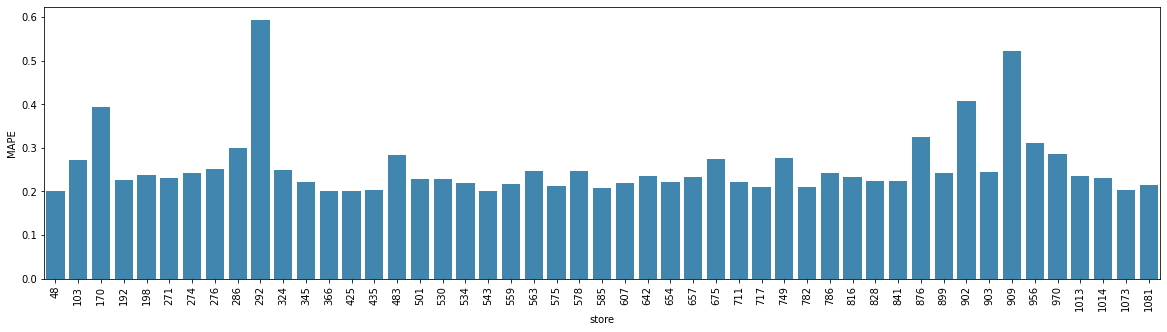

In [105]:
plt.figure(figsize=(20, 5))
sns.barplot(data=df92[df92['MAPE'] >= 0.20], x='store', y='MAPE', color='#2E8BC0')
plt.xticks(rotation=90);


## 9.1. Business Performance

In [106]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].sum().reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].apply('R$ {:,.2f}'.format, axis=1)
df93

,Scenario,Values
0,predictions,"R$ 285,931,264.00"
1,worst_scenario,"R$ 285,070,186.13"
2,best_scenario,"R$ 286,792,338.56"


## 9.3. Machine Learning Performance

<AxesSubplot:xlabel='predictions', ylabel='error'>

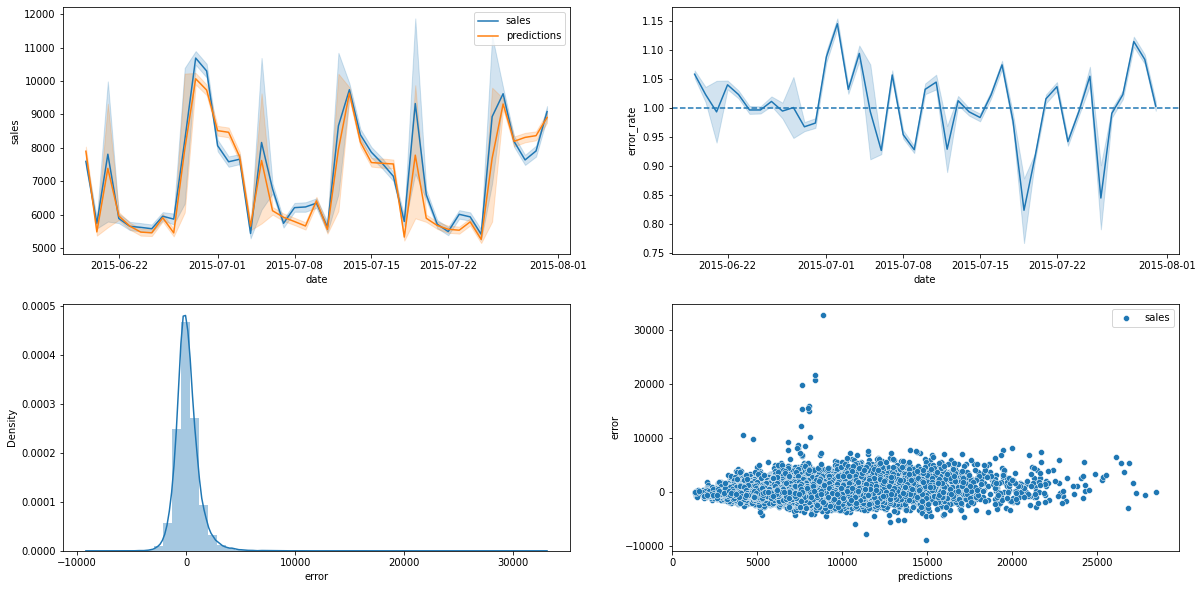

In [107]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)
sns.lineplot(data=df9, x='date', y='sales', label='sales')
sns.lineplot(data=df9, x='date', y='predictions', label='predictions')

plt.subplot(2, 2, 2)
sns.lineplot(data=df9, x='date', y='error_rate')
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(data=df9, x='predictions', y='error', label='sales')


# 10. DEPLOY MODEL TO PRODUCTION

## 10.1 Rossmann Class

In [108]:
import pandas as pd
import pickle
import inflection
import math
import numpy as np
import datetime

class Rossmann(object):
    def __init__(self):
        
        # scalers
#         self.home_path = '/rossmann-store-sales/'
        self.scaler_competition_distance = pickle.load(open('../parameters/scaler_competition_distance.pkl', 'rb'))
        self.scaler_year = pickle.load(open('../parameters/scaler_year.pkl', 'rb'))
        self.scaler_competition_time_month = pickle.load(open('../parameters/scaler_competition_time_month.pkl', 'rb'))
        self.scaler_promo_time_week = pickle.load(open('../parameters/scaler_promo_time_week.pkl', 'rb'))
        
        # encoders
        self.encoder_store_type = pickle.load(open('../parameters/encoder_store_type.pkl', 'rb'))
        
    def data_cleaning (self, df1):
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        def snakecase(x):
            return inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6. Change Types
        # Competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        
        # Promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1

    
    def feature_engineering(self, df2):

        ## 2.3. Feature Engineering

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')


        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Seleção das colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2

    
    def data_preparation(self, df5):
        
        ## 5.2 Rescaling
        # competition_distance
        df5['competition_distance'] = self.scaler_competition_distance.transform(df5[['competition_distance']].values)

        # year
        df5['year'] = self.scaler_year.transform(df5[['year']].values)

        # competition_time_month
        df5['competition_time_month'] = self.scaler_competition_time_month.transform(df5[['competition_time_month']].values)

        # promo_time_week
        df5['promo_time_week'] = self.scaler_promo_time_week.transform(df5[['promo_time_week']].values)

        ## 5.3 Transformation
        ### 5.3.1 Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.encoder_store_type.transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 Nature Transformation

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * 2 * np.pi / 7))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * 2 * np.pi / 7))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * 2 * np.pi / 12))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * 2 * np.pi / 12))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * 2 * np.pi / 30))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * 2 * np.pi / 30))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * 2 * np.pi / 52))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * 2 * np.pi / 52))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment',  'competition_distance',
                         'competition_open_since_month', 'competition_open_since_year', 'promo2',
                         'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
                         'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [109]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('../model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0]) # unique example
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys()) # multiple example
            
        # instanciate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # predictions
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run()

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [110]:
import json
import requests

# loading test dataset
df10_test = pd.read_csv('./data/test.csv')
df10_store = pd.read_csv('./data/store.csv')
df10 = pd.merge(df10_test, df10_store, on='Store', how='left')

# choose store for prediction
df10 = df10[df10['Store'].isin([22, 24, 56])]

# removed closed
df10 = df10[df10['Open'] != 0]
df10 = df10[~df10['Open'].isnull()]
df10 = df10.drop('Id', axis=1)

In [111]:
# convert DataFrame to json
data = json.dumps(df10.to_dict(orient='records'))

In [112]:
# API call
# url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'http://al-model-rossmann.herokuapp.com/rossmann/predict' # Heroku
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status code: {}'.format(r.status_code))

Status code: 200


In [113]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [114]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store number {} will sell R$ {:,.2f} in the next 6 weeks.'.format(d2['store'][i], d2['prediction'][i]))

Store number 22 will sell R$ 185,865.77 in the next 6 weeks.
Store number 24 will sell R$ 372,503.14 in the next 6 weeks.
Store number 56 will sell R$ 307,927.36 in the next 6 weeks.
